## Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import YouTube videos' title data

In [2]:
import pickle
import os

from textblob import TextBlob, Word, Blobber
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

import os

baseurl = '/content/drive/MyDrive/Datalist'

os.chdir('/content/drive/MyDrive/')



# download nltk dataset for sentiment analysis
nltk.download('all')

## youtube module load from drive folder
import youtube.ytf


os.chdir(baseurl)
yt_titles = []
yt_vid_metadata = []
for filename in os.listdir(baseurl):
  f = os.path.join(baseurl, filename)
  if os.path.isfile(f):
    print('Unpacking file : '+baseurl + '/' + filename)
    ytfile = open(f, "rb")
    ytraw = pickle.load(ytfile)
    for vid in ytraw: # extract video text description
      if type(vid.image) is not list:
        yt_titles.append(vid.title)
        # create meta-data dict
        yt_vid_metadata.append({'vidLabels':vid.videoLabels,'vidFeatures':vid.videoNumFeatures,'vidSentiment':[]})
    ytfile.close()


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

Unpacking file : /content/drive/MyDrive/Datalist/datalist10_rgb.pkl
Unpacking file : /content/drive/MyDrive/Datalist/datalist11_rgb.pkl
Unpacking file : /content/drive/MyDrive/Datalist/datalist12_rgb.pkl
Unpacking file : /content/drive/MyDrive/Datalist/datalist13_rgb.pkl
Unpacking file : /content/drive/MyDrive/Datalist/datalist14_rgb.pkl
Unpacking file : /content/drive/MyDrive/Datalist/datalist1_0_10_rgb.pkl
Unpacking file : /content/drive/MyDrive/Datalist/datalist2_11_20_rgb.pkl
Unpacking file : /content/drive/MyDrive/Datalist/datalist3_21_26_rgb.pkl
Unpacking file : /content/drive/MyDrive/Datalist/datalist4_27_35_rgb.pkl
Unpacking file : /content/drive/MyDrive/Datalist/datalist5_36_43_rgb.pkl
Unpacking file : /content/drive/MyDrive/Datalist/datalist6_44_77_rgb.pkl
Unpacking file : /content/drive/MyDrive/Datalist/datalist7_rgb.pkl
Unpacking file : /content/drive/MyDrive/Datalist/datalist8_rgb.pkl
Unpacking file : /content/drive/MyDrive/Datalist/datalist9_rgb.pkl


## NLP Sentiment Analysis of the YouTube Video Titles
## Links: 
## https://realpython.com/python-nltk-sentiment-analysis-using-nltks-pre-trained-sentiment-analyzer
## https://github.com/cjhutto/vaderSentiment

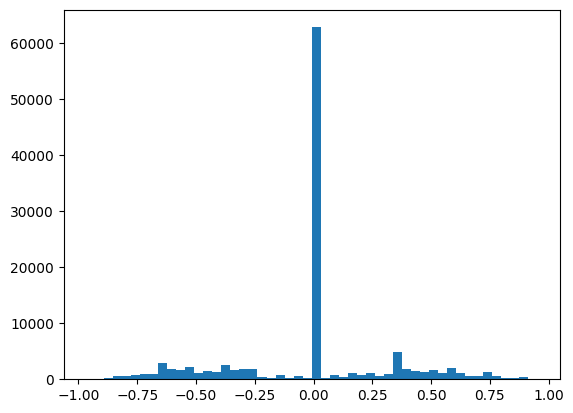

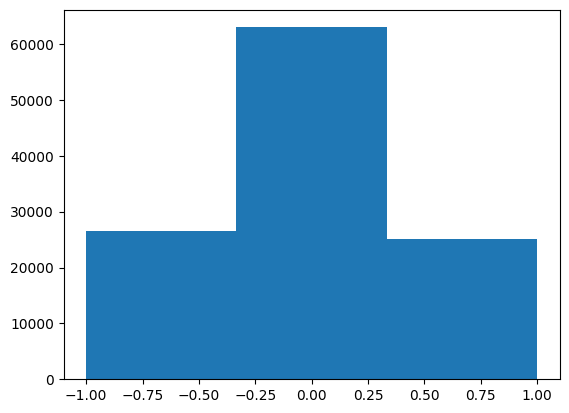

In [3]:
import matplotlib.pyplot as plt

senti = SentimentIntensityAnalyzer() # initialize sentiment analyzer, use compound score to choose categorical variable of whether the 
# title is of positive, negative or neutral sentiment
'''positive sentiment: compound score >= 0.05
neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
negative sentiment: compound score <= -0.05

The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive).
This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. 
Calling it a 'normalized, weighted composite score' is accurate.

'''

'''
Added granularity: -0.025 - 0.025 - 0,
                   0.025 - 0.05 - +1, >0.05 - +2,
                   -0.05 -  -0.025 - -1, < -0.05 - -2,

'''

yt_titles_compoundscores = [] # list to store compound score of each video's title's sentiment score
yt_titles_sentiments = [] # list to store sentiment as a categorical variable
polarity_thresh = 0.05 # = 0.05 per SentimentIntensityAnalyzer()'s documentation
for title in yt_titles:
  cp_score = list(senti.polarity_scores(title).values())[-1]
  yt_titles_compoundscores.append(cp_score) # dictionary's last element is compound score
  if cp_score >= polarity_thresh:
    yt_titles_sentiments.append(1) # positive sentiment
  elif cp_score >= -polarity_thresh:
    yt_titles_sentiments.append(0) # neutral sentiment
  else:
    yt_titles_sentiments.append(-1) # negative sentiment
  # elif cp_score >= -polarity_thresh_high:
  #   yt_titles_sentiments.append(-1) # negative sentiment
  # else:
  #   yt_titles_sentiments.append(-2) # highly negative sentiment

# Plot histograms of both arrays
plt.hist(yt_titles_compoundscores,bins = 50)
plt.show()

plt.hist(yt_titles_sentiments,bins = 3)
plt.show()

## Update list of YouTube videos' metadata dictionary

In [4]:
for index,sentiment_score in enumerate(yt_titles_sentiments):
  yt_vid_metadata[index]['vidSentiment'] = sentiment_score

# Save to Google Drive

os.chdir('/content/drive/MyDrive/')
with open('yt_metadata.pkl', 'wb') as handle:
  pickle.dump(yt_vid_metadata, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Combine Video Metadata and low-dim embedding of video thumbnails (computed from autoencoder architecture - reconstruction error (normalized) - 3%)

In [5]:
# combine video meta-data and low dim embedding, and pickle save
import os
import pickle
os.chdir('/content/drive/MyDrive/')
import io
import torch

# custom class for unpickling tensor objects, and mapping to cpu byte by byte
class CPU_Unpickler(pickle.Unpickler):
  def find_class(self, module, name):
    if module == 'torch.storage' and name == '_load_from_bytes':
      return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
    else:
      return super().find_class(module, name)

#contents = pickle.load(f) becomes...
with open('thumbnail_grayscale_embeddings.pkl','rb') as f:
  embeddings = CPU_Unpickler(f).load()

assert len(yt_vid_metadata) == len(embeddings)

yt_video_metadata_with_embeddings = []
for index in range(len(yt_vid_metadata)):
  metadata = yt_vid_metadata[index]
  metadata['thumbnail_embedding'] = embeddings[index]
  yt_video_metadata_with_embeddings.append(metadata)

# Save to Google Drive

os.chdir('/content/drive/MyDrive/')
with open('yt_metadata_with_embeddings.pkl', 'wb') as handle:
  pickle.dump(yt_video_metadata_with_embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Cluster embeddings using tSNE and assign frame to each video

In [6]:
!pip install opentsne
from openTSNE import TSNE
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 5.8 MB/s eta 0:00:00


In [7]:
%%time
indices = np.random.permutation(list(range(len(embeddings))))
reverse = np.argsort(indices)

emb_ratio = 1
num_samples_init = int(emb_ratio*len(embeddings))

emb_sample = [embeddings[index] for index in indices[:num_samples_init]]
emb_rest = [embeddings[index] for index in indices[num_samples_init:]]

# t-SNE
embedding_tsne = TSNE(
    perplexity=75,
    initialization="pca",
    metric="euclidean",
    exaggeration=8,
    n_jobs=32,
    random_state=3,
).fit(np.array(embeddings))

CPU times: user 15min 18s, sys: 8.18 s, total: 15min 26s
Wall time: 9min 58s


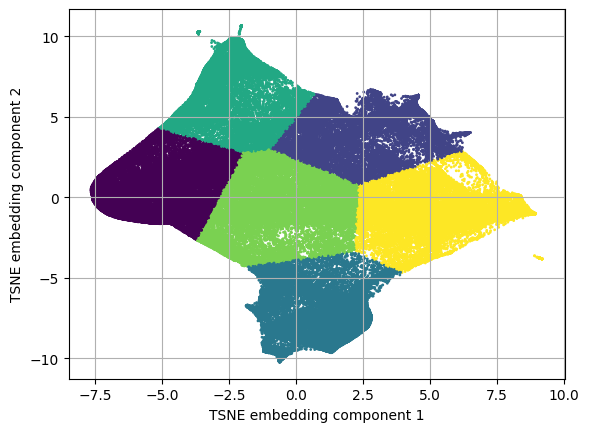

The silhouette score for n_clusters = 6 is : 0.15011168


In [ ]:
# KMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

n_clusters = 6
kmeans_labels = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit_predict(embedding_tsne)
plt.scatter(embedding_tsne[:,0],embedding_tsne[:,1],s=1,c = kmeans_labels)
plt.xlabel('TSNE embedding component 1')
plt.ylabel('TSNE embedding component 2')
plt.grid('on')
plt.show()
sil_score = silhouette_score(embeddings,kmeans_labels)
print('The silhouette score for n_clusters = {} is : '.format(n_clusters) + str(sil_score))

In [ ]:
kmeans_labels[0]

2

## SAVE CATEGORY AFTER KMEANS TO METADATA Dictionary

In [ ]:
yt_videos_metadata_complete = []
for index in range(len(yt_video_metadata_with_embeddings)):
  metadata = yt_video_metadata_with_embeddings[index]
  metadata['cluster_category'] = kmeans_labels[index]
  yt_videos_metadata_complete.append(metadata)


# Save to Google Drive

os.chdir('/content/drive/MyDrive/')
with open('yt_metadata_complete.pkl', 'wb') as handle:
  pickle.dump(yt_videos_metadata_complete, handle, protocol=pickle.HIGHEST_PROTOCOL)